In [61]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import json
import os
from pprint import pprint
import helper
from importlib import reload
%matplotlib notebook

Here is a practical example of how we can use photogrammetry. In this example, we can use a Rubik's Cube. First, let's read in the images.

<IPython.core.display.Javascript object>


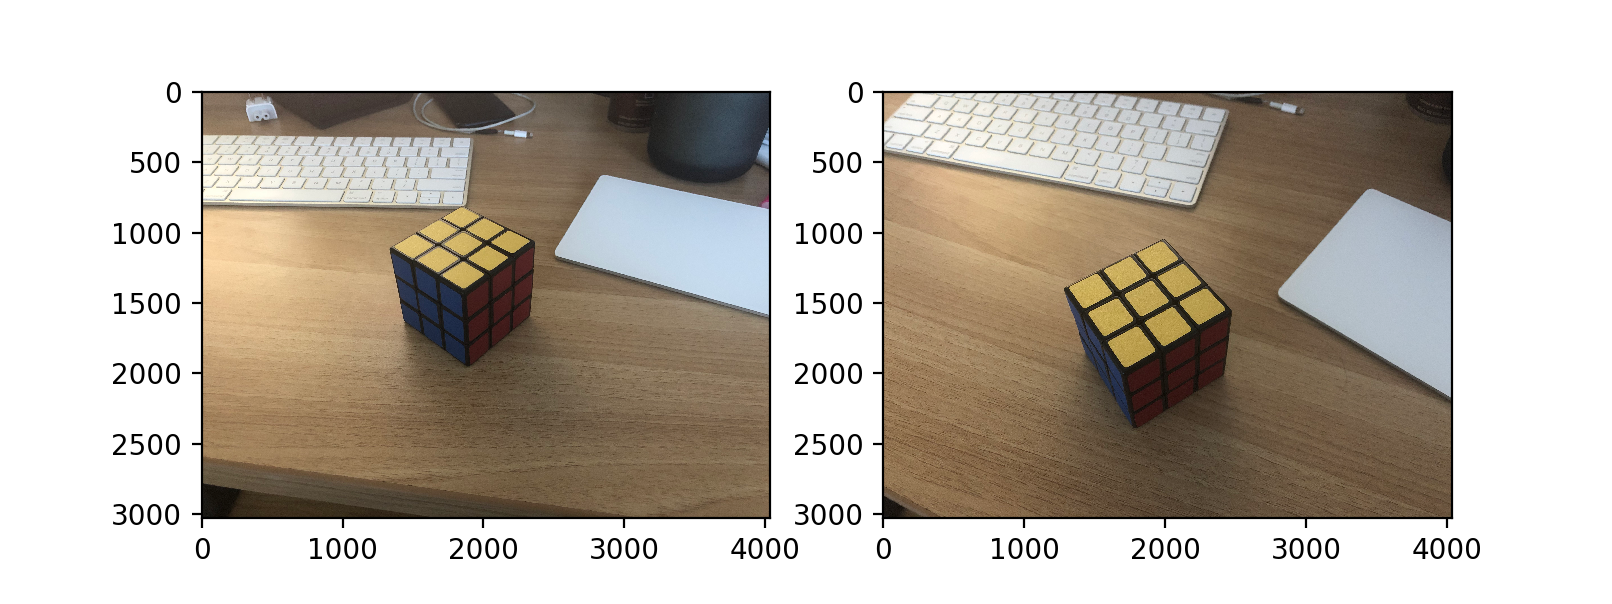

In [73]:
img1 = cv2.imread('images/IMG_0269.png')
img2 = cv2.imread('images/IMG_0270.png')
fig, axes = plt.subplots(
    1, 2,
    figsize = (img1.shape[1]/1000 * 2, img1.shape[0]/1000)
)
axes[0].imshow(img1[...,::-1])
axes[1].imshow(img2[...,::-1])
plt.show()

So after reading this images in, we can *manually* label the features we will use to relate the two images.

<IPython.core.display.Javascript object>


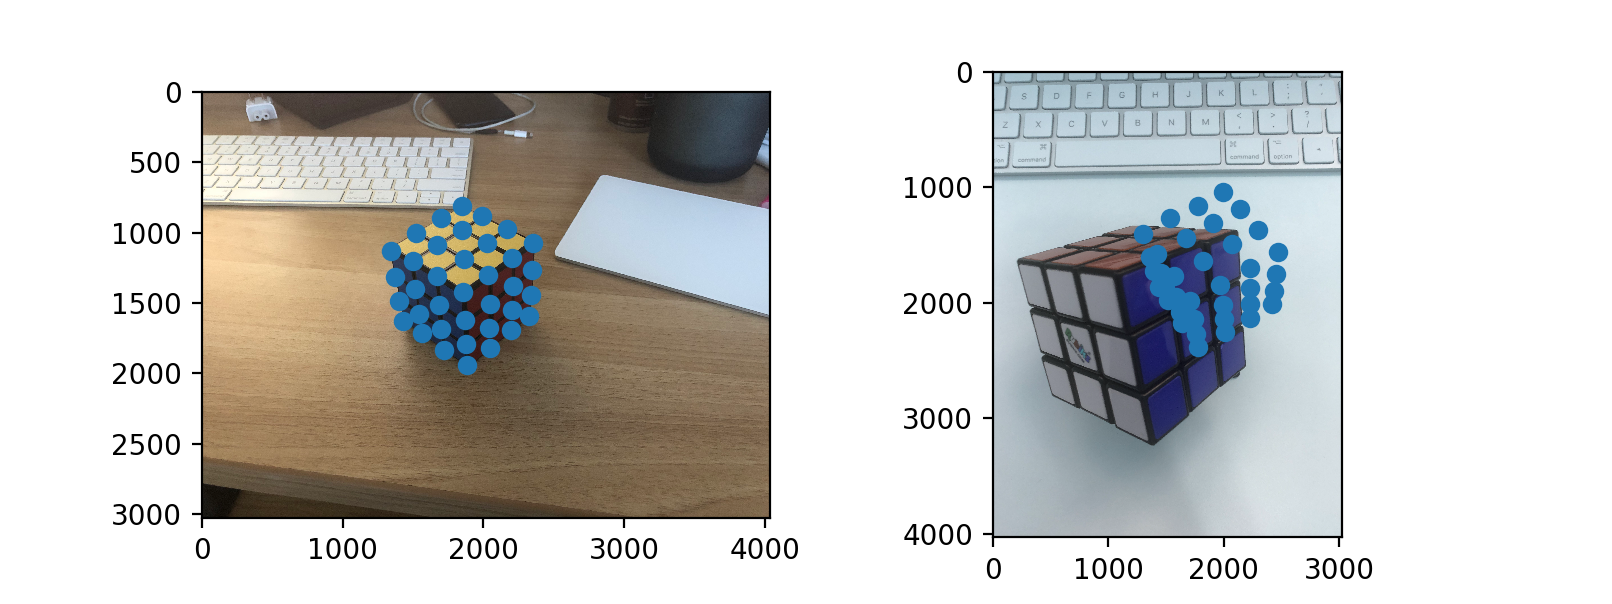

In [74]:
img1_p = [
    # Blue-Orange Edge
    (1342, 1130), (1371, 1312), (1402, 1485), (1429, 1628), 
    (1497, 1202), (1516, 1400), (1540, 1579), (1561, 1715), 
    (1673, 1308), (1681, 1512), (1699, 1687), (1719, 1830),
    # Blue-Red Edge
    (1854, 1424), (1866, 1618), (1875, 1791), (1883, 1942), 
    (2029, 1302), (2046, 1506), (2042, 1677), (2046, 1818), 
    (2201, 1184), (2209, 1381), (2200, 1548), (2194, 1695),
    # Red-Green Edge
    (2353, 1073), (2345, 1267), (2337, 1446), (2323, 1591), 
    # Yellow Top Square (West counter-clockwise)
    (1520, 1001), (1673, 1091), (1859, 1190), (2024, 1077), 
    (2168, 975), (1991, 885), (1844, 813), (1702, 898), 
    (1847, 984)
]
img2_p = [
    # Blue-Orange Edge
    (1301, 1404), (1360, 1607), (1395, 1723), (1441, 1867), 
    (1420, 1574), (1455, 1738), (1493, 1875), (1517, 1972), 
    (1564, 1770), (1584, 1948), (1619, 2080), (1637, 2174),
    # Blue-Red Edge
    (1710, 1983), (1739, 2144), (1762, 2273), (1780, 2381), 
    (1964, 1843), (1994, 2021), (2002, 2144), (2008, 2253), 
    (2222, 1702), (2230, 1872), (2222, 2013), (2222, 2133),
    # Red-Green Edge
    (2465, 1562), (2450, 1752), (2430, 1899), (2418, 2013), 
    # Yellow Top Square (West counter-clockwise)
    (1534, 1269), (1670, 1437), (1821, 1634), (2068, 1493), 
    (2292, 1368), (2137, 1190), (1989, 1038), (1775, 1160), 
    (1906, 1308)
]
fig, axes = plt.subplots(
    1, 2,
    figsize = (img1.shape[1]/1000 * 2, img1.shape[0]/1000)
)
axes[0].imshow(img1[...,::-1])
axes[0].scatter(
    [pt[0] for pt in img1_p], [pt[1] for pt in img1_p]
)
axes[1].imshow(img2[...,::-1])
axes[1].scatter(
    [pt[0] for pt in img2_p], [pt[1] for pt in img2_p]
)
plt.show()

Let's first say that there *will* be an error. Let's start!

## Scaling the Points

So the first step in this process will be to scale, $N$, and translate the image points, `x_n`, so that the centroid, $t$, of the points is found at the origin.

In [88]:
x_n = np.matrix(
    [[pt[0] for pt in img1_p], [pt[1] for pt in img1_p]]
)
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N

In [89]:
t.shape

(2, 1)

With the centroid, $t$, of the points, we can calculate the distance, `xnc`, from the centered points, `dc`, and the image centroid. We can use the $t$ as the basis and scale the points to have an average distance of $\sqrt{2}$ from the origin. This helps us ensure that or distribution is normal.

In [90]:
xnc = x_n - t * np.ones((1, N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg

In [91]:
np.matrix(
    [[pt[0] for pt in img1_p], [pt[1] for pt in img1_p], np.ones(len(img1_p))]
)

matrix([[1.342e+03, 1.371e+03, 1.402e+03, 1.429e+03, 1.497e+03,
         1.516e+03, 1.540e+03, 1.561e+03, 1.673e+03, 1.681e+03,
         1.699e+03, 1.719e+03, 1.854e+03, 1.866e+03, 1.875e+03,
         1.883e+03, 2.029e+03, 2.046e+03, 2.042e+03, 2.046e+03,
         2.201e+03, 2.209e+03, 2.200e+03, 2.194e+03, 2.353e+03,
         2.345e+03, 2.337e+03, 2.323e+03, 1.520e+03, 1.673e+03,
         1.859e+03, 2.024e+03, 2.168e+03, 1.991e+03, 1.844e+03,
         1.702e+03, 1.847e+03],
        [1.130e+03, 1.312e+03, 1.485e+03, 1.628e+03, 1.202e+03,
         1.400e+03, 1.579e+03, 1.715e+03, 1.308e+03, 1.512e+03,
         1.687e+03, 1.830e+03, 1.424e+03, 1.618e+03, 1.791e+03,
         1.942e+03, 1.302e+03, 1.506e+03, 1.677e+03, 1.818e+03,
         1.184e+03, 1.381e+03, 1.548e+03, 1.695e+03, 1.073e+03,
         1.267e+03, 1.446e+03, 1.591e+03, 1.001e+03, 1.091e+03,
         1.190e+03, 1.077e+03, 9.750e+02, 8.850e+02, 8.130e+02,
         8.980e+02, 9.840e+02],
        [1.000e+00, 1.000e+00, 1.000e+00

```
TODO
----
- Rename the skew symmetric matrix
```
Now we can create a skew-symmetric matrix, $t$, with the scale factor and the distance from the centroid previously calculated. 

In [92]:
t_1 = np.zeros((2,2), float)
np.fill_diagonal(t_1, s)
t_1 = np.vstack(
    [np.hstack([t_1, -s * t]), [0, 0, 1]]
)
points_1_scaled = t_1 * np.matrix(
    [[pt[0] for pt in img1_p], [pt[1] for pt in img1_p], np.ones(len(img1_p))]
)

So that's the first image. Let's apply the same method to the points in the second image.

In [93]:
x_n = np.matrix(
    [[pt[0] for pt in img2_p], [pt[1] for pt in img2_p]]
)
N = x_n.shape[1]
t = np.sum(x_n, axis=1) / N
xnc = x_n - t * np.ones((1, N))
dc = np.sqrt(np.sum(np.power(xnc, 2).transpose(), axis=1))
d_avg = 1 / N * np.sum(dc)
s = np.sqrt(2) / d_avg
t_2 = np.zeros((2,2), float)
np.fill_diagonal(t_2, s)
t_2 = np.vstack(
    [np.hstack([t_2, -s * t]), [0, 0, 1]]
)
points_2_scaled = t_2 * np.matrix(
    [[pt[0] for pt in img2_p], [pt[1] for pt in img2_p], np.ones(len(img2_p))]
)

## Calculating the Essential Matrix

So we have the corresponding points in both images normalized. Now we can use **Singular Value Decomposition** to solve for the **Essential Matrix**. Let's use an $A$ matrix,

$$A = \begin{pmatrix} x_{0}x_{1} & x_{0}y_{1} & x_{0} & y_{0}x_{1} & y_{0}y_{1} & y_{0} & x_{1} & y_{1} & 1 \end{pmatrix}\text{,}$$

with $n$ unique coordinates shared between the images, having a shape of $n \times 9$.

In [133]:
A = np.hstack([
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[0,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[0,:].transpose(),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[0,:].transpose()),
    np.multiply(points_1_scaled[1,:].transpose(), points_2_scaled[1,:].transpose()),
    points_1_scaled[1,:].transpose(),
    points_2_scaled[0,:].transpose(),
    points_2_scaled[1,:].transpose(),
    np.matrix(np.ones(N)).transpose()
])
[U, D, V] = np.linalg.svd(A)
x = V[8, :]
E_scaled = np.reshape(V[8, :].tolist(), (3, 3))

In [134]:
E_scaled

array([[ 0.01347608,  0.02437401,  0.63272177],
       [-0.02589694, -0.01087555,  0.32414457],
       [-0.56195553, -0.42081338, -0.01228498]])

**Singular Value Decomposition** produces the decomposed matrix. We must force the rank of the **Essential Matrix** to be $2$ and have equal Eigenvalues.

In [132]:
[U, D, V] = np.linalg.svd(E_scaled)
# U[:,[0, 1]] = U[:,[1, 0]]
E_scaled = U * np.diag([1, 1, 0]) * V.transpose()
E_scaled

array([[ 0.33393835, -0.        ,  0.        ],
       [ 0.        , -0.14455506,  0.        ],
       [-0.        ,  0.        ,  0.        ]])

After forcing the rank of the **Essential Matrix**, we can calculate the **Fundamental Matrix**.

In [135]:
t_1

matrix([[ 3.51753088e-03,  0.00000000e+00, -6.54650524e+00],
        [ 0.00000000e+00,  3.51753088e-03, -4.84516112e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [136]:
t_1.transpose() * E_scaled * t_2

matrix([[ 1.46180473e-07,  2.64394693e-07,  1.48572153e-03],
        [-2.80914479e-07, -1.17971471e-07,  1.87020323e-03],
        [-1.61808162e-03, -1.62727835e-03,  1.60770049e-01]])

In [96]:
E_compute =  t_1.transpose() * E_scaled * t_2
E_compute[:,[0, 1]] = E_compute[:,[1, 0]]
E_compute

matrix([[ 0.00000000e+00,  3.62236312e-06, -6.71566542e-03],
        [-1.56804666e-06,  0.00000000e+00,  2.78082479e-03],
        [ 2.15987832e-03, -6.74160938e-03,  8.66818111e+00]])

## Recovering Motion from the Essential Matrix

With the constructed **Essential Matrix**, we can recover the motion between the two camera positions. We know that the **Essential Matrix** is composed of the translation, $[t]_{x}$, and rotation, $R$. The higher dimensionality of this problem requires us to simplify the problem by using **Singular Value Decomposition**:

$$
E = UDV^{T}\text{.}
$$

Because we are dealing with projections, the math is limited to in front of or behind the camera. This translates to either $u_{3}$ or $-u_{3}$. With this in mind, the rotation is either $UWV^{T}$ or $UW^{T}V^{T}$, where

$$
W = \begin{pmatrix}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix} \text{.}
$$

With two possible translations and two possible rotations, we have four possible results. Since we know the points need to be in front of both images, we can chose the correct result out of the four possible.

The solution is homogeneous. This means that it can be scaled by any constant, $k$. An unknown scale only limits the translation, meaning the rotation is known, but the translation is scaled by an arbitrary amount:

$$
kE=k[t]_x R\text{.}
$$

In [128]:
U, D, VT = np.linalg.svd(E_compute)
U[:,[0, 1]] = U[:,[1, 0]]
V = VT.transpose()
V[:,[0, 1]] = V[:,[1, 0]]
W = np.matrix([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
])

In [129]:
U[:,2]

matrix([[-8.03797952e-01],
        [-5.94902232e-01],
        [-4.31892134e-04]])

In [130]:
np.hstack([U@W@V.transpose(),  U[:,2]])

matrix([[ 5.56326578e-01,  5.79845254e-01,  5.95214431e-01,
         -8.03797952e-01],
        [ 4.10788997e-01,  4.30737372e-01, -8.03565627e-01,
         -5.94902232e-01],
        [-7.22324815e-01,  6.91552455e-01,  1.43659783e-03,
         -4.31892134e-04]])

After solving for the $U$, $W$, and $V$, we can compute the four possible solutions.

In [137]:
results = [
    np.vstack([np.hstack([U@W@V.transpose(),  U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W@V.transpose(), -U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W.transpose()@V.transpose(),  U[:,2]]), [0,0,0,1]]),
    np.vstack([np.hstack([U@W.transpose()@V.transpose(), -U[:,2]]), [0,0,0,1]])
]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 37)

These results can now be reconstructed in three dimensional space. Let's construct a model that fits the given constraints:

$$
Z_{1}p_{1}=M_{1}P \\
Z_{2}p_{2}=M_{2}P 
$$

where 

$$
M_{1} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{pmatrix} \text{.}
$$

In [123]:
M_1 = np.matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]
])

In order to solve for the $P$ matrix, we must solve for $M_{2}$:

$$
M_{2} = \begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_{x} \\
r_{21} & r_{22} & r_{23} & t_{y} \\
r_{31} & r_{32} & r_{33} & t_{z}
\end{pmatrix}
=
\begin{pmatrix}
^{2}_{1}R & ^{2}t_{1orig}
\end{pmatrix}\text{.}
$$

The projected point, $p_{1}$, and the observed point, $M_{1}P$, are parallel; their cross product must be $0$. The same is known for the projected point in the second image. This gives us the constraint: 

$$
p_{1}\times M_{1}P=0\\
p_{2}\times M_{2}P=0\text{.}
$$

$P$ can be solved by using least squares:

$$
\begin{bmatrix}
[(p_{1})_x] M_{1} \\
[(p_{2})_x] M_{2}
\end{bmatrix}
P = 0\text{.}
$$

*Note:* This is solved using a single point found in both projections. Let's pick a point.

<IPython.core.display.Javascript object>


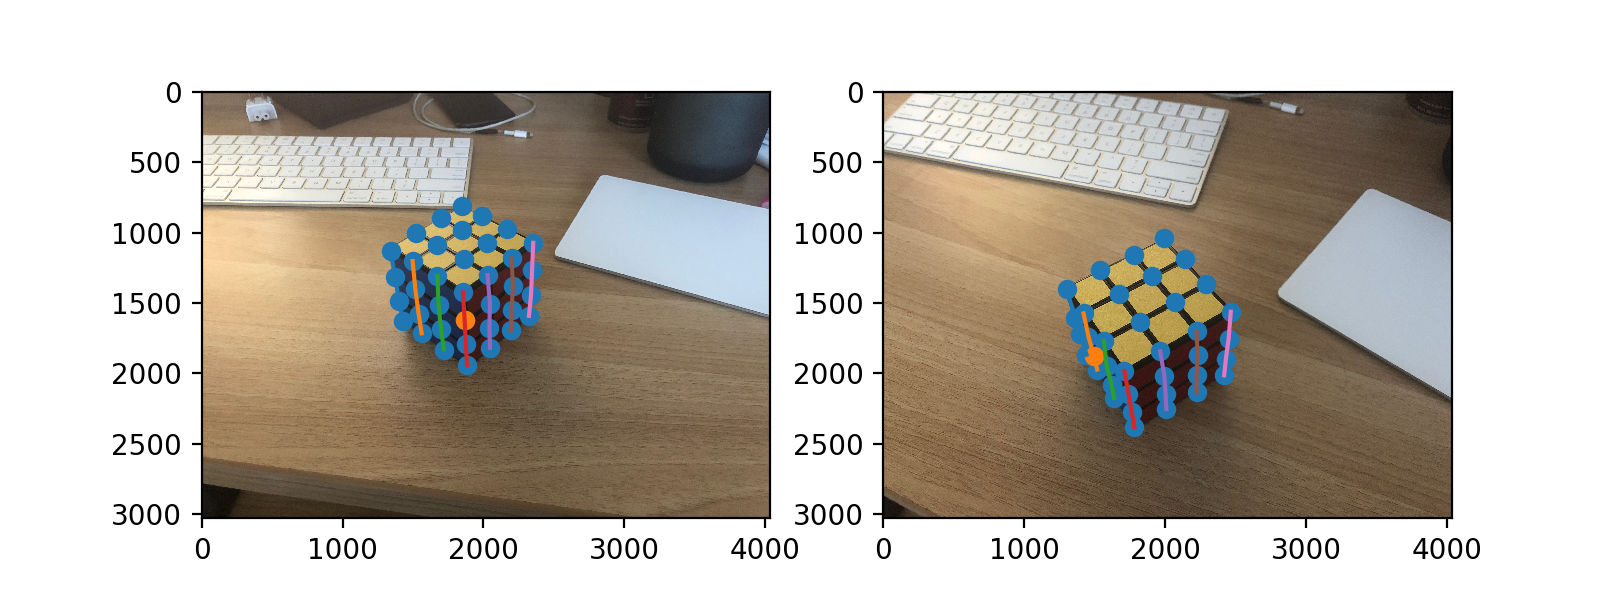

In [124]:
n = 13

fig, axes = plt.subplots(
    1, 2,
    figsize = (img1.shape[1]/1000 * 2, img1.shape[0]/1000)
)
axes[0].imshow(img1[...,::-1])
axes[0].scatter(
    [pt[0] for pt in img1_p], [pt[1] for pt in img1_p]
)
axes[0].scatter(img1_p[n][0], img1_p[n][1])
for n in range(7):
    axes[0].plot(
        [p[0] for p in img1_p[n * 4:n * 4 + 4]],
        [p[1] for p in img1_p[n * 4:n * 4 + 4]]
    )
axes[1].imshow(img2[...,::-1])
axes[1].scatter(
    [pt[0] for pt in img2_p], [pt[1] for pt in img2_p]
)
axes[1].scatter(img2_p[n][0], img2_p[n][1])
for n in range(7):
    axes[1].plot(
        [p[0] for p in img2_p[n * 4:n * 4 + 4]],
        [p[1] for p in img2_p[n * 4:n * 4 + 4]]
    )
plt.show()

In [125]:
p_1_x = np.matrix([
    [0, -1, points_1_scaled[1].tolist()[0][n]],
    [1, 0, -points_1_scaled[0].tolist()[0][n]],
    [-points_1_scaled[1].tolist()[0][n], points_1_scaled[0].tolist()[0][n], 0]
])
p_2_x = np.matrix([
    [0, -1, points_2_scaled[1].tolist()[0][n]],
    [1, 0, -points_2_scaled[0].tolist()[0][n]],
    [-points_2_scaled[1].tolist()[0][n], points_2_scaled[0].tolist()[0][n], 0]
])
p_1_x

matrix([[ 0.        , -1.        ,  0.70902014],
        [ 1.        ,  0.        ,  1.12950769],
        [-0.70902014, -1.12950769,  0.        ]])

We can calculate the four possible solutions using the selected point and the composed $p_{1}$ and $p_{2}$ matrices.

In [126]:
for result in results:
    if np.linalg.det(result[0:2,0:2]) < 0:
        result = -result
    U, D, V = np.linalg.svd(
        np.vstack([
            [p_1_x @ M_1],
            [p_2_x @ np.linalg.inv(result)[0:3,:]]
        ])
    )
    P = V[-1]
    P_1_est = P / P[0,-1]
    P_2_est = np.linalg.inv(result) @ P_1_est.transpose()
    if P_1_est[2,0] > 0 and P_2_est[2,0] > 0:
        answer = -result
answer

matrix([[ 5.54910408e-01,  5.81841691e-01, -5.94587829e-01,
          8.03797952e-01],
        [ 4.11653213e-01,  4.29043566e-01,  8.04029384e-01,
          5.94902232e-01],
        [ 7.22921899e-01, -6.90928264e-01, -1.43626114e-03,
          4.31892134e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])

With the only possible solution, we have found the $M_{2}$ and the rotation, $R$, and translation $t$.

In [81]:
M_2_est = np.linalg.inv(answer)[0:3,:]
P_est = []
for n in range(N):
    p_1_x = np.matrix([
        [0, -1, points_1_scaled[1].tolist()[0][n]],
        [1, 0, -points_1_scaled[0].tolist()[0][n]],
        [-points_1_scaled[1].tolist()[0][n], points_1_scaled[0].tolist()[0][n], 0]
    ])
    p_2_x = np.matrix([
        [0, -1, points_2_scaled[1].tolist()[0][n]],
        [1, 0, -points_2_scaled[0].tolist()[0][n]],
        [-points_2_scaled[1].tolist()[0][n], points_2_scaled[0].tolist()[0][n], 0]
    ])
    U, D, V = np.linalg.svd(
        np.vstack([
            p_1_x @ M_1,
            p_2_x @ M_2_est
        ])
    )
    P = V[-1]
    P_est.append((P / P[0, -1]).tolist()[0][0:3]) 

The estimated points have now been calculated using the chosen coordinate and the estimated $M_{2}$ matrix. We can plot these coordinates in three dimensions.

<IPython.core.display.Javascript object>


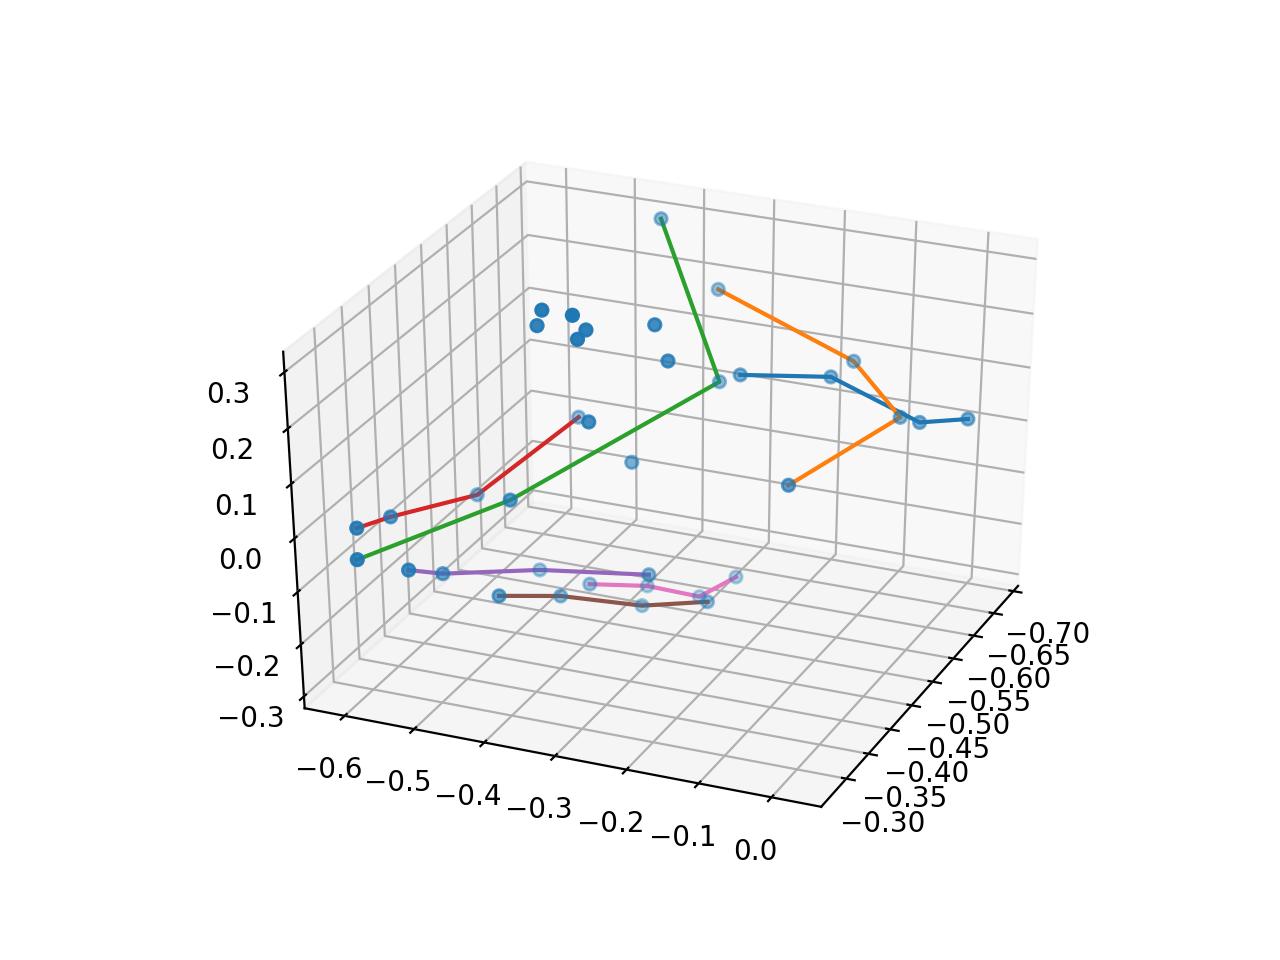

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    [point[0] for point in P_est],
    [point[1] for point in P_est],
    [point[2] for point in P_est]
)
for n in range(7):
    ax.plot(
        [p[0] for p in P_est[n * 4:n * 4 + 4]],
        [p[1] for p in P_est[n * 4:n * 4 + 4]],
        [p[2] for p in P_est[n * 4:n * 4 + 4]]
    )
plt.show()

In [138]:
points_1_scaled

matrix([[-1.8259788 , -1.72397041, -1.61492695, -1.51995361, -1.28076151,
         -1.21392843, -1.12950769, -1.05563954, -0.66167608, -0.63353583,
         -0.57022028, -0.49986966, -0.02500299,  0.01720738,  0.04886516,
          0.07700541,  0.59056491,  0.65036294,  0.63629282,  0.65036294,
          1.19558023,  1.22372047,  1.1920627 ,  1.17095751,  1.73024492,
          1.70210467,  1.67396443,  1.62471899, -1.1998583 , -0.66167608,
         -0.00741534,  0.57297726,  1.07950171,  0.45689874, -0.0601783 ,
         -0.55966768, -0.04962571],
        [-0.87035122, -0.2301606 ,  0.37837224,  0.88137916, -0.617089  ,
          0.07938212,  0.70902014,  1.18740434, -0.24423073,  0.47334557,
          1.08891348,  1.59192039,  0.16380286,  0.84620385,  1.45473669,
          1.98588385, -0.26533591,  0.45224039,  1.05373817,  1.54971002,
         -0.68040455,  0.01254903,  0.59997669,  1.11705373, -1.07085048,
         -0.38844949,  0.24118854,  0.75123051, -1.32411271, -1.00753493,
  

In [96]:
img1 = cv2.imread('images/1.JPG')
img2 = cv2.imread('images/2.JPG')

In [30]:
fig, ax = plt.subplots(
    figsize = (img1.shape[1]/500, img1.shape[0]/500)
)
ax.imshow(img1[...,::-1])
for face in config["1.JPG"]["FACES"].keys():
    for point in config["1.JPG"]["FACES"][face]:
        ax.scatter(point[0], point[1], color=face)
for corner_color_key in config["1.JPG"]["CORNERS"].keys():
    corner_colors = corner_color_key.split("-")
    for color_index in range(len(corner_colors)):
        ax.scatter(
            config["1.JPG"]["CORNERS"][corner_color_key][0],
            config["1.JPG"]["CORNERS"][corner_color_key][1],
            color=corner_colors[color_index],
            s=10 * (color_index + 1),
            zorder= 3 - color_index
        )

NameError: name 'img1' is not defined

In [156]:
image_dir = 'images'
with open('config.json') as f:
    config = json.load(f)
images = list(config.keys())
pprint(config[images[0]]["CORNERS"])
pprint(config[images[1]]["CORNERS"])

{'BLUE-ORANGE-WHITE': [730, 1825],
 'BLUE-ORANGE-YELLOW': [1522, 1526],
 'BLUE-RED-WHITE': [1795, 2091],
 'BLUE-RED-YELLOW': [2470, 1701],
 'GREEN-ORANGE-WHITE': [866, 2916],
 'GREEN-RED-WHITE': [1847, 3370],
 'GREEN-RED-YELLOW': [2392, 2721]}
{'BLUE-ORANGE-WHITE': [743, 1818],
 'BLUE-ORANGE-YELLOW': [1541, 1513],
 'BLUE-RED-WHITE': [1808, 2065],
 'BLUE-RED-YELLOW': [2502, 1695],
 'GREEN-ORANGE-WHITE': [879, 2909],
 'GREEN-RED-WHITE': [1866, 3351],
 'GREEN-RED-YELLOW': [2418, 2727]}


In [192]:
known_corners = config[images[0]]["CORNERS"]
config[images[0]]["MATCHED-CORNERS"] = {}
for face in config[images[0]]["FACES"].keys():
    config[images[0]]["MATCHED-CORNERS"][face] = {}
    known_corners = {
        corner_name:config[images[0]]["CORNERS"][corner_name] 
        for corner_name in config[images[0]]["CORNERS"] 
        if face in corner_name
    }
    for square_coord in config[images[0]]["FACES"][face]:
        distances = np.array([
            np.sqrt(
                np.power((corner_coord[0] - square_coord[0]), 2) \
                + np.power((corner_coord[1] - square_coord[1]), 2)
            )
            for corner_coord in known_corners.values()
        ])
        closest_corner = list(known_corners.keys())[
            np.where(distances == distances.min())[0][0]
        ]
        config[images[0]]["MATCHED-CORNERS"][face][closest_corner + "-FACE"] = square_coord
        del known_corners[closest_corner]
pprint(config[images[0]]["MATCHED-CORNERS"])

{'BLUE': {'BLUE-ORANGE-WHITE-FACE': [1580, 1655],
          'BLUE-ORANGE-YELLOW-FACE': [1327, 1768],
          'BLUE-RED-WHITE-FACE': [1664, 1831],
          'BLUE-RED-YELLOW-FACE': [1905, 1714]},
 'RED': {'BLUE-RED-WHITE-FACE': [2061, 2351],
         'BLUE-RED-YELLOW-FACE': [2262, 2565],
         'GREEN-RED-WHITE-FACE': [2275, 2188],
         'GREEN-RED-YELLOW-FACE': [2067, 2753]},
 'WHITE': {'BLUE-ORANGE-WHITE-FACE': [1054, 2292],
           'BLUE-RED-WHITE-FACE': [1405, 2409],
           'GREEN-ORANGE-WHITE-FACE': [1093, 2695],
           'GREEN-RED-WHITE-FACE': [1438, 2831]}}


In [197]:
for image in config.keys():
    config[image]["IMAGE"] = cv2.imread(os.path.join(image_dir, image))
    config[image]["MATCHED-CORNERS"] = {}
    for face in config[image]["FACES"].keys():
        config[image]["MATCHED-CORNERS"][face] = {}
        known_corners = {
            corner_name:config[image]["CORNERS"][corner_name] 
            for corner_name in config[image]["CORNERS"] 
            if face in corner_name
        }
        for square_coord in config[images[0]]["FACES"][face]:
            distances = np.array([
                np.sqrt(
                    np.power((corner_coord[0] - square_coord[0]), 2) \
                    + np.power((corner_coord[1] - square_coord[1]), 2)
                )
                for corner_coord in known_corners.values()
            ])
            closest_corner = list(known_corners.keys())[
                np.where(distances == distances.min())[0][0]
            ]
            config[image]["MATCHED-CORNERS"][face][closest_corner + "-FACE"] = square_coord
            del known_corners[closest_corner]

<IPython.core.display.Javascript object>


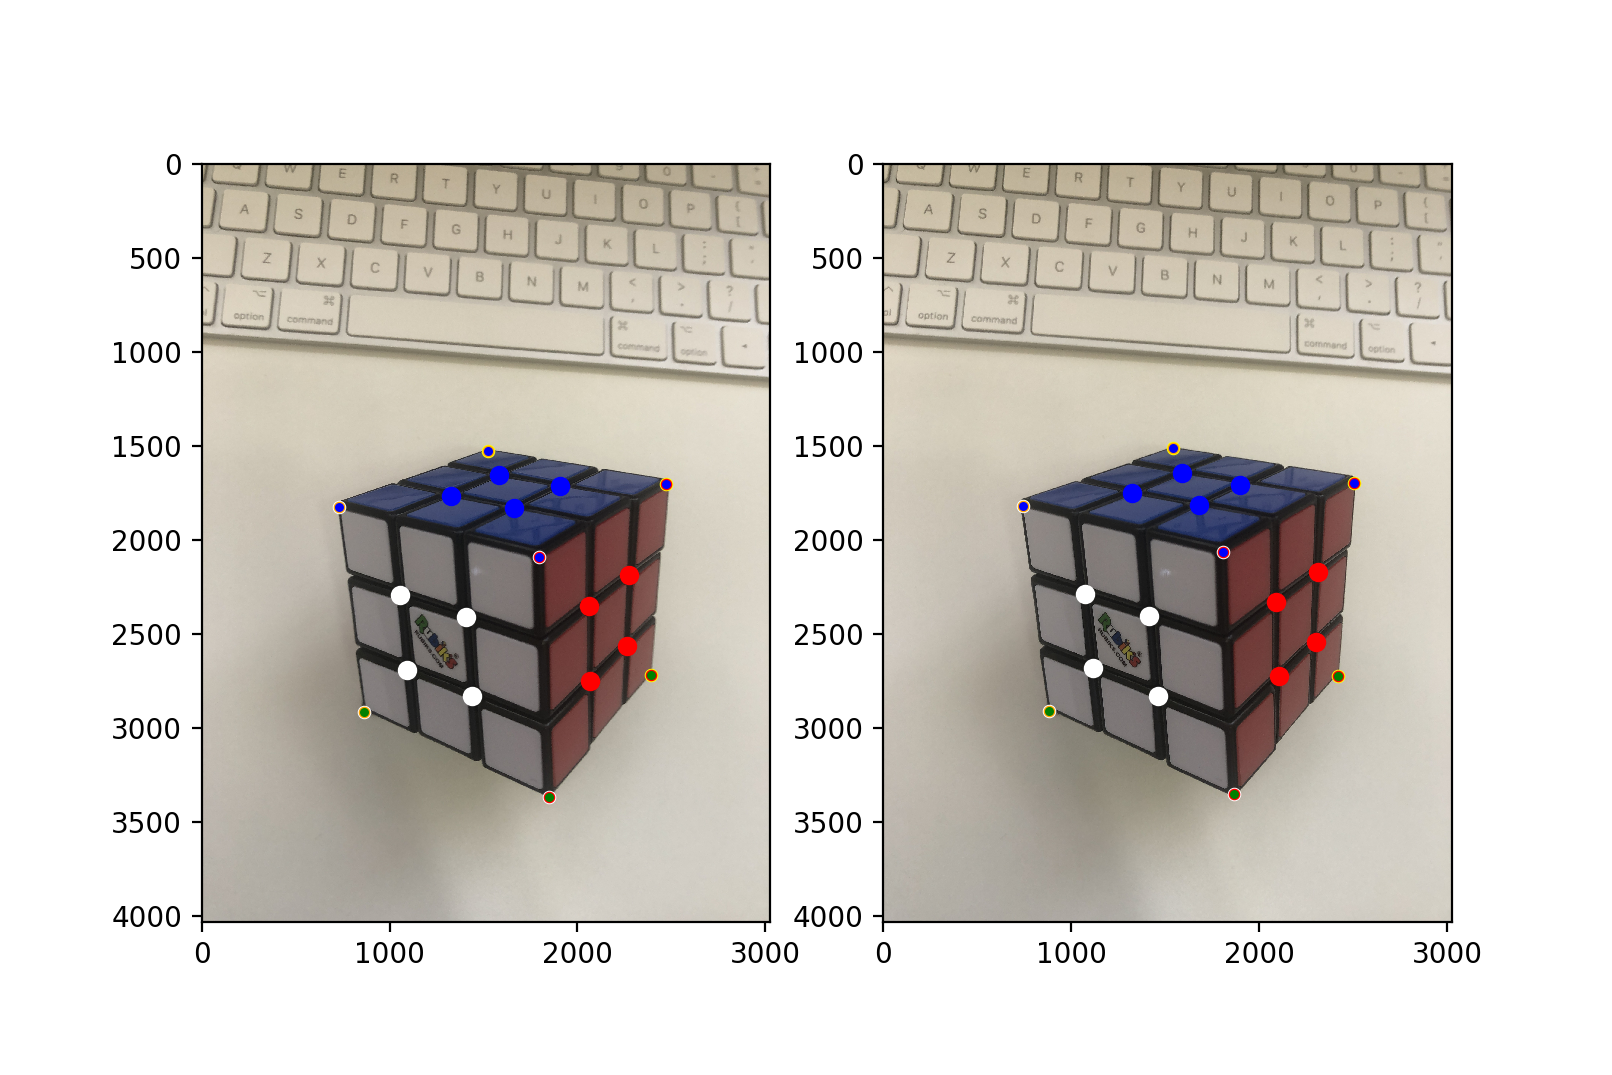

In [59]:
reload(helper)
config = helper.read_images("config.json", "images")
image_1 = list(set(config))[0]
image_2 = list(set(config))[1]
matched_points = helper.match_points(image_1, image_2, config)
helper.show_images(image_1, image_2, config)

The helper package allows us to read in the images, read the selected features, and match the features between the two images.

<IPython.core.display.Javascript object>


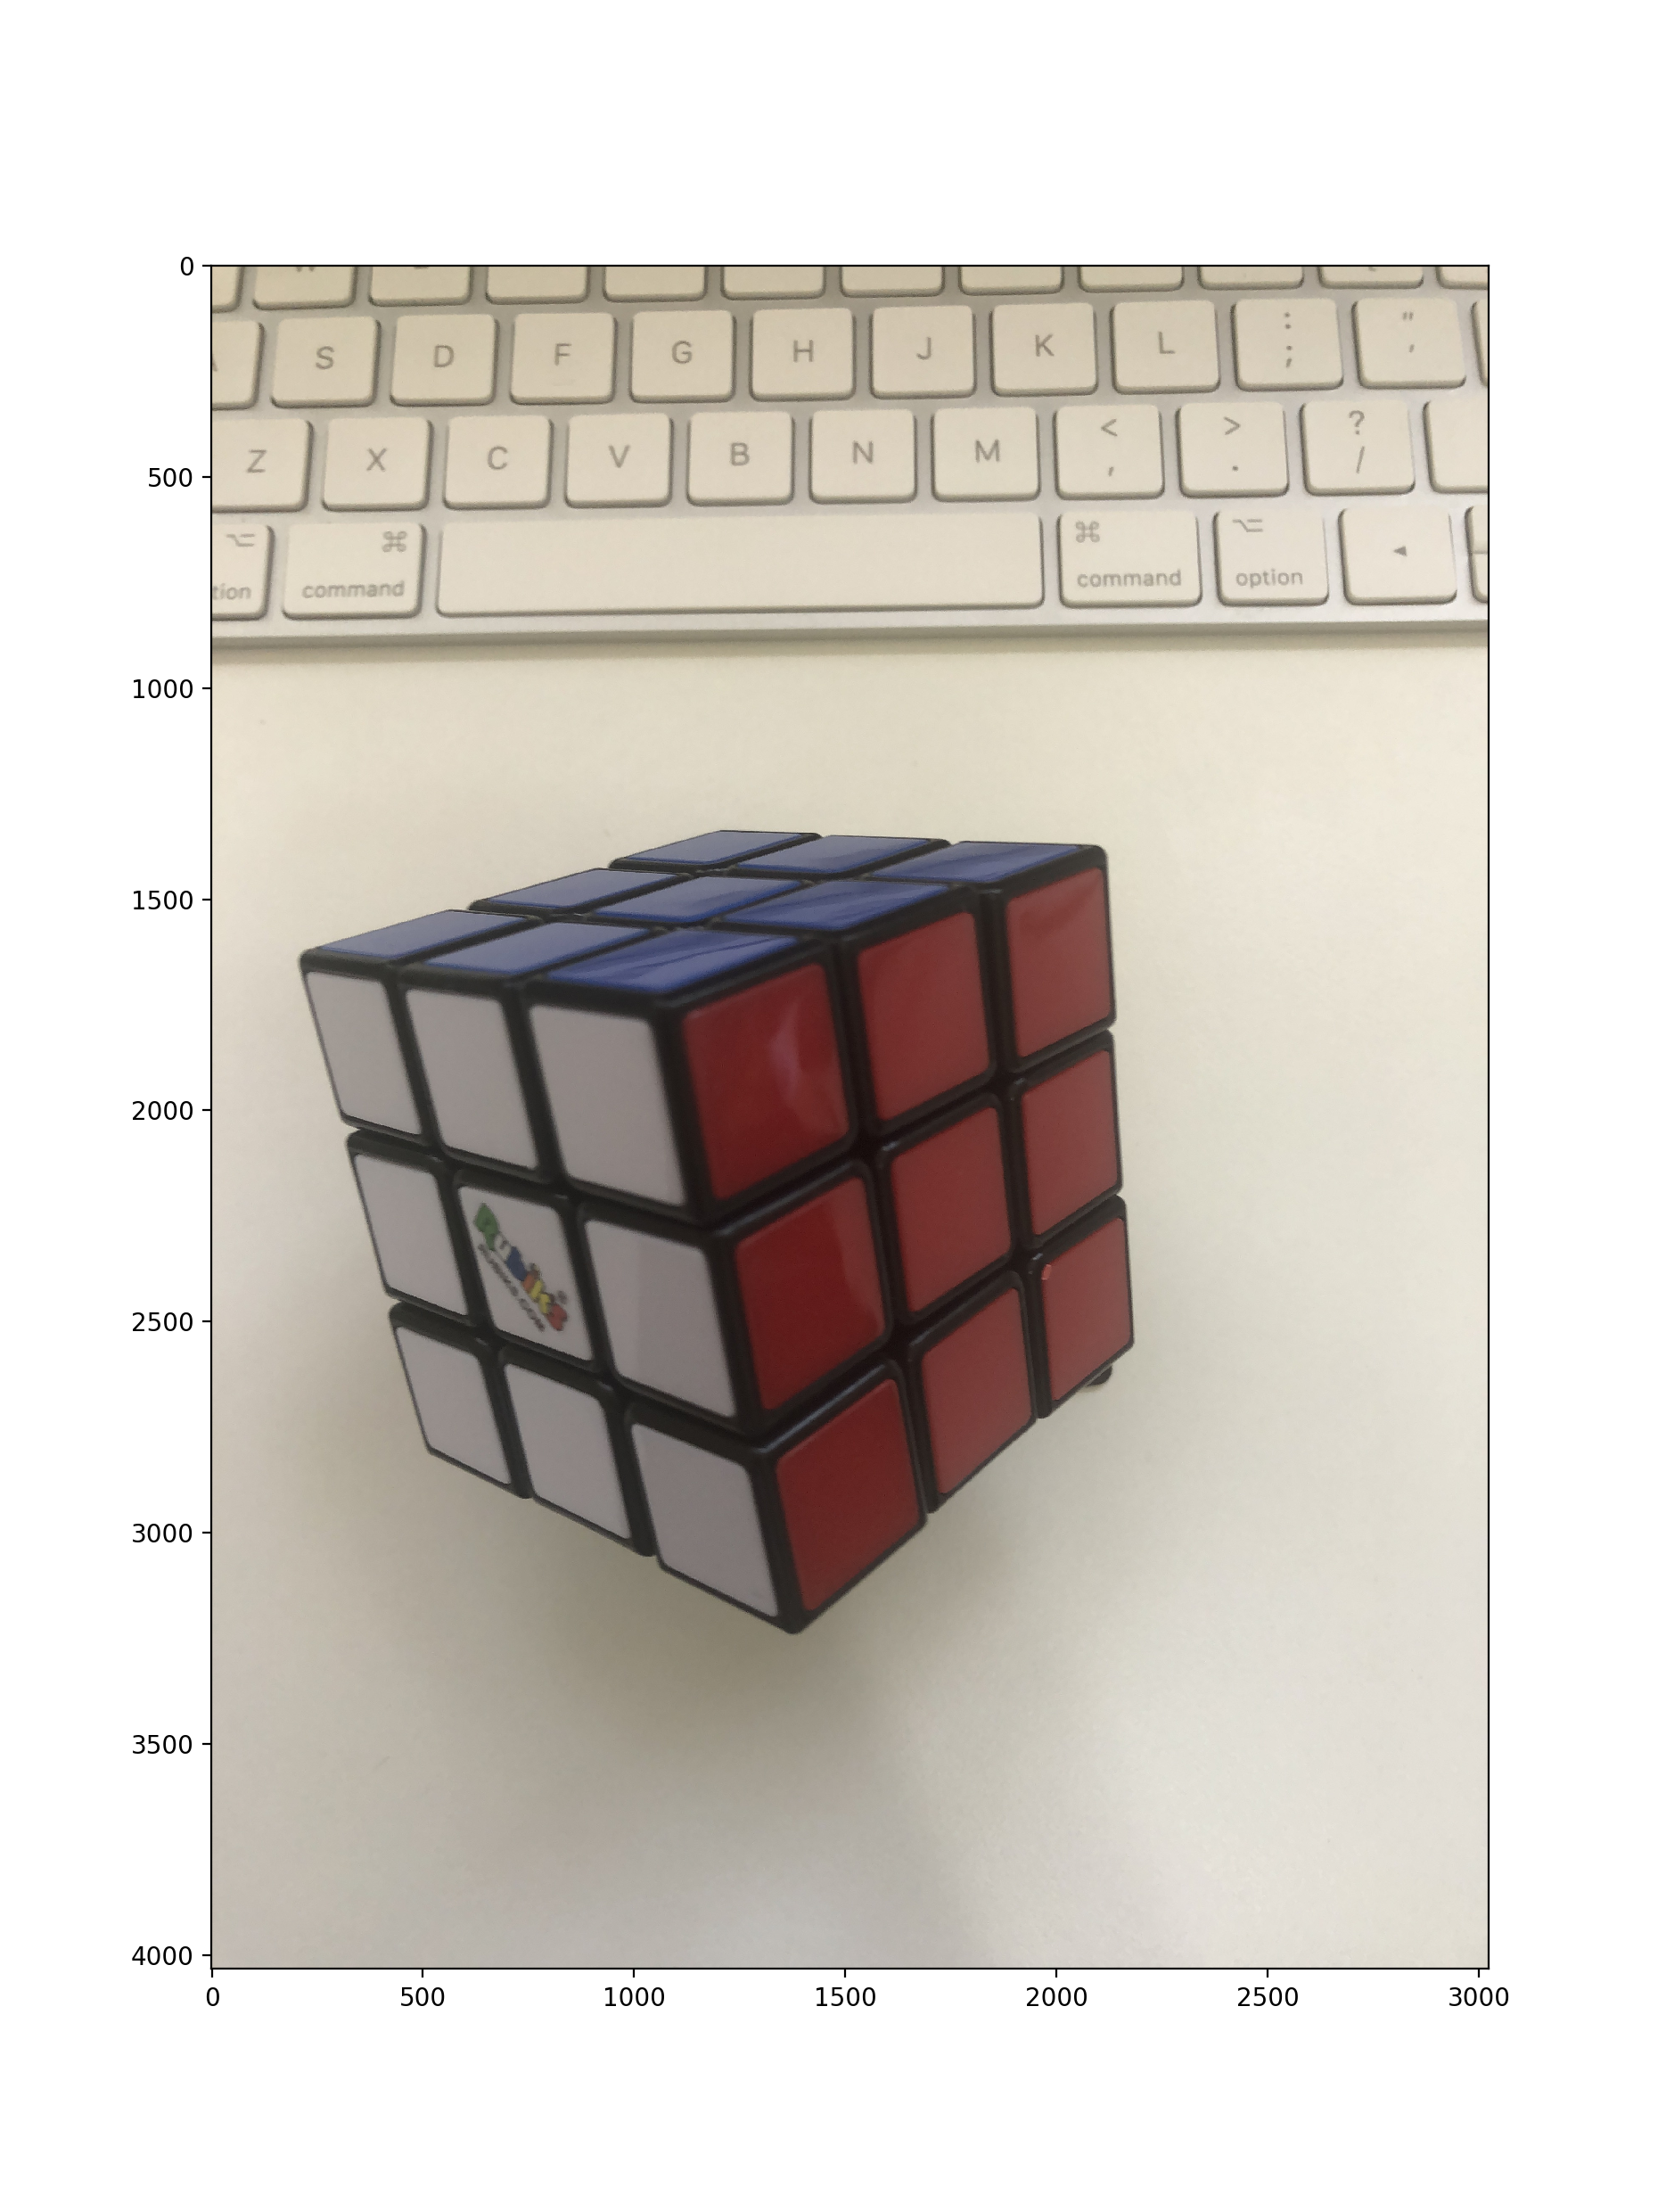

In [118]:
image_3 = "3.JPG"
image = cv2.imread(os.path.join("images", image_3))
fig, ax = plt.subplots(
    figsize=(
        config[image_1]["IMAGE"].shape[1]/325, 
        config[list(set(config))[0]]["IMAGE"].shape[0]/325
    )
)
ax.imshow(image[...,::-1])
plt.show()

In [ ]:
config = {
    "3.JPG":{
        "FACES": {
            "WHITE":[
                [544, 2123],
                [658, 2550],
                [957, 2668],
                [839, 2199]
            ],
            "BLUE":[
                [818, 1549],
                [1122, 1566],
                [1472, 1460],
                [1168, 1443]
            ],
            "RED":[
                [1557, 2094],
                [1637, 2554],
                [1928, 2364],
                [1877, 1937]
            ]
        },
        "CORNERS":{
            "BLUE-ORANGE-WHITE": [215, 1655],
            "GREEN-ORANGE-WHITE": [514, 2811],
            "BLUE-RED-WHITE": [1071, 1777],
            "GREEN-RED-WHITE": [1384, 3233],
            "BLUE-RED-YELLOW": [2110, 1405],
            "GREEN-RED-YELLOW": [2186, 2554],
            "BLUE-ORANGE-YELLOW": [1206, 1342]
        }
    }
}